### **Load Libraries/Packages**

In [40]:
# Load packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


import time
import copy
import os
from itertools import product
import random

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


torch.manual_seed(42)

### **Data Download & Preprocessing**

In [4]:
# Normalize iamge pixel values
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# load the datatset and further split it into training and testing sets
trainval_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Further split training set to training set and validation set with ratio of 80/20
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

# Create data loaders, allow batching and shuffling data
# large batch size so that model processmore at once
# small batch size to reduce memory useage adn speed up evaluation process, as no gradient computation during validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:04<00:00, 34.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### **Display Images**

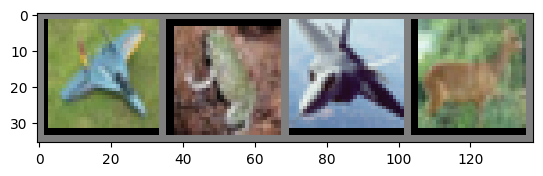

In [5]:
# Display Image Funnction
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Randomly diplay some pictures
image_iter = iter(train_loader)
images, labels = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))


### **Accuracy & Loss Curve Illustration Plot**

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name="Model"):

    epochs = range(1, len(train_losses) + 1)

    # Plotting the loss curves
    plt.figure(figsize=(14, 6))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### **Confusion Matrix**

In [ ]:
# Function to calculate and print class-wise metrics
def plot_confusion_matrix(model, test_loader, classes, device="cuda"):
    # Collect all predictions and true labels
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    print("\n--- Class-wise Performance Metrics ---")
    class_report = classification_report(all_labels, all_preds, target_names=classes)
    print(class_report)

    # Calculate and plot class-wise accuracy
    cm = confusion_matrix(all_labels, all_preds)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=class_accuracies)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Class-wise Accuracy for ResNet-18 on CIFAR-10 Test Set")
    plt.ylim(0, 1)
    plt.show()

### **Visualize Testing Performance**

In [ ]:
def visualize_test_results(test_loader, model, device, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 6))
    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])
        image = images[idx].cpu().numpy().transpose((1, 2, 0))
        ax.imshow(image)
        ax.set_title(f"Pred: {preds[idx].item()}, True: {labels[idx].item()}")

## **Model Architectures**

### **ResNet-18**

In [6]:
# Constructing ResNet-18 starts from defining blocks that consist of convolutional layers ans skipp connections
# Updated ResNet-18 with configurable dropout rate
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input, output, stride=1, downsampling=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output, output, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)

        return out


In [7]:
# Defining the ResNet-18 architecture with customizations for our dataset
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.input = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Define each ResNet layer with residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, output, blocks, stride=1):
        downsampling = None
        if stride != 1 or self.input != output * block.expansion:
            downsampling = nn.Sequential(
                nn.Conv2d(self.input, output * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output * block.expansion),
            )
        layers = []
        layers.append(block(self.input, output, stride, downsampling))
        self.input = output * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.input, output))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Function to initialize ResNet-18
def ResNet_18(num_classes=10, dropout_rate=0.5):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, dropout_rate=dropout_rate)

### **AlexNet**

In [15]:
# # Defining the AlexNet architecture with dropout regularization
# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Fully connected layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Weight initialization function
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)



In [16]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save the model when validation loss decreases.'''
        torch.save(model.state_dict(), 'checkpoint.pth')


### **MobileNet**

In [17]:
# Define the MobileNetV2 Inverted Residual Block
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = (self.stride == 1 and in_channels == out_channels)

        layers = []
        if expand_ratio != 1:
            # Pointwise convolution (expand)
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))

        # Depthwise convolution
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))

        # Pointwise convolution (project)
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [18]:
# Defining the MobileNetV2 architecture with variable width multiplier for tuning
# Define MobileNetV2 model
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0, dropout_rate=0.2):
        super(MobileNetV2, self).__init__()
        input_channel = 32
        last_channel = 1280

        inverted_residual_config = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 1],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        self.features = [nn.Conv2d(3, input_channel, kernel_size=3, stride=1, padding=1, bias=False),
                         nn.BatchNorm2d(input_channel),
                         nn.ReLU6(inplace=True)]

        # Building inverted residual blocks
        for t, c, n, s in inverted_residual_config:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # Last convolution layer
        self.features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, stride=1, padding=0, bias=False))
        self.features.append(nn.BatchNorm2d(last_channel))
        self.features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*self.features)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

    # Weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




## **Hyperparameters Tuning**

#### **Hyperparameters Space**

In [16]:
# Define the hyperparameter space
hyperparameter_space = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [32, 64, 128],
    "optimizer": ["Adam", "SGD"],
    "weight_decay": [0.0001, 0.0005, 0.001],
    "scheduler_step_size": [10, 20],
    "scheduler_gamma": [0.5, 0.9]}


### **Trainning & Evaluation Function**

In [34]:
# Function to train the model for one epoch and calculate training loss and accuracy
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

# Evaluation function: Calculates validation loss and accuracy after each epoch
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_test_loss = test_loss / total
    test_accuracy = 100. * correct / total

    return avg_test_loss, test_accuracy, all_labels, all_preds



### **Early Stopping**

In [20]:
# Early stopping function
# EarlyStopping class: Implements early stopping to prevent overfitting based on validation loss
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


### **Random Search Optimization**

In [19]:
# Function to perform random search over hyperparameters for a given model architecture
def random_search(model_class, hyperparameter_space, train_dataset, val_dataset, num_trials=10, num_epochs=20, device="cuda"):
    results = []

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        lr = random.choice(hyperparameter_space["learning_rate"])
        batch_size = random.choice(hyperparameter_space["batch_size"])
        optimizer_name = random.choice(hyperparameter_space["optimizer"])
        weight_decay = random.choice(hyperparameter_space["weight_decay"])
        scheduler_step_size = random.choice(hyperparameter_space["scheduler_step_size"])
        scheduler_gamma = random.choice(hyperparameter_space["scheduler_gamma"])

        print(f"Trial {trial + 1}/{num_trials}: "
              f"lr={lr}, batch_size={batch_size}, optimizer={optimizer_name}, "
              f"weight_decay={weight_decay}, step_size={scheduler_step_size}, gamma={scheduler_gamma}")

        # Initialize DataLoader for this trial's batch size
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, criterion, optimizer, and scheduler
        model = model_class(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()

        if optimizer_name == "Adam":
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

        scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)


        # Integrate early stopping in the training loop
        early_stopping = EarlyStopping(patience=3)

        # Training and validation loop
        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            scheduler.step()

                # Check early stopping criteria
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break

            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Record results for this configuration
        results.append({
            "learning_rate": lr,
            "batch_size": batch_size,
            "optimizer": optimizer_name,
            "weight_decay": weight_decay,
            "scheduler_step_size": scheduler_step_size,
            "scheduler_gamma": scheduler_gamma,
            "val_accuracy": val_acc
        })

    return pd.DataFrame(results)


##### **Best Params -- ResNet18**

In [22]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run random search for each model
print("\n--- Random Search for ResNet-18 ---")
resnet_results = random_search(ResNet_18, hyperparameter_space, train_dataset, val_dataset, device=device)



--- Random Search for ResNet-18 ---
Trial 1/10: lr=0.0005, batch_size=128, optimizer=Adam, weight_decay=0.0005, step_size=10, gamma=0.5
Epoch 1/20 - Train Loss: 1.5277, Train Acc: 44.21% - Val Loss: 1.5280, Val Acc: 47.94%
Epoch 2/20 - Train Loss: 1.0340, Train Acc: 63.28% - Val Loss: 0.9726, Val Acc: 66.16%
Epoch 3/20 - Train Loss: 0.8437, Train Acc: 70.29% - Val Loss: 0.8120, Val Acc: 71.42%
Epoch 4/20 - Train Loss: 0.7252, Train Acc: 75.11% - Val Loss: 0.8444, Val Acc: 70.48%
Epoch 5/20 - Train Loss: 0.6438, Train Acc: 77.95% - Val Loss: 0.6386, Val Acc: 77.69%
Epoch 6/20 - Train Loss: 0.5880, Train Acc: 80.03% - Val Loss: 0.7888, Val Acc: 72.90%
Epoch 7/20 - Train Loss: 0.5421, Train Acc: 81.47% - Val Loss: 0.7032, Val Acc: 76.73%
Early stopping triggered
Trial 2/10: lr=0.0005, batch_size=128, optimizer=Adam, weight_decay=0.001, step_size=10, gamma=0.9
Epoch 1/20 - Train Loss: 1.5436, Train Acc: 43.25% - Val Loss: 1.2820, Val Acc: 54.34%
Epoch 2/20 - Train Loss: 1.0651, Train Acc:

####  **Best Params -- AlexNet**



In [21]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n--- Random Search for AlexNet ---")
alexnet_results = random_search(AlexNet, hyperparameter_space, train_dataset, val_dataset, device=device)


--- Random Search for AlexNet ---
Trial 1/10: lr=0.001, batch_size=32, optimizer=SGD, weight_decay=0.001, step_size=10, gamma=0.9
Epoch 1/20 - Train Loss: 2.3033, Train Acc: 10.12% - Val Loss: 2.3024, Val Acc: 10.24%
Epoch 2/20 - Train Loss: 2.3027, Train Acc: 9.91% - Val Loss: 2.3026, Val Acc: 9.73%
Epoch 3/20 - Train Loss: 2.3028, Train Acc: 9.89% - Val Loss: 2.3025, Val Acc: 9.67%
Early stopping triggered
Trial 2/10: lr=0.001, batch_size=32, optimizer=Adam, weight_decay=0.0005, step_size=10, gamma=0.9
Epoch 1/20 - Train Loss: 2.0149, Train Acc: 19.02% - Val Loss: 1.8139, Val Acc: 28.06%
Epoch 2/20 - Train Loss: 1.7773, Train Acc: 29.13% - Val Loss: 1.6682, Val Acc: 34.21%
Epoch 3/20 - Train Loss: 1.6713, Train Acc: 34.55% - Val Loss: 1.5657, Val Acc: 40.09%
Epoch 4/20 - Train Loss: 1.5777, Train Acc: 39.90% - Val Loss: 1.4670, Val Acc: 45.34%
Epoch 5/20 - Train Loss: 1.5045, Train Acc: 43.98% - Val Loss: 1.4180, Val Acc: 47.39%
Epoch 6/20 - Train Loss: 1.4453, Train Acc: 47.19% - V

#### **Best Params -- MobileNetV2**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n--- Random Search for MobileNetV2 ---")
mobilenet_results = random_search(MobileNetV2, hyperparameter_space, train_dataset, val_dataset, device=device)


--- Random Search for MobileNetV2 ---
Trial 1/10: lr=0.0001, batch_size=32, optimizer=Adam, weight_decay=0.0001, step_size=20, gamma=0.9
Epoch 1/20 - Train Loss: 1.8637, Train Acc: 30.43% - Val Loss: 1.6106, Val Acc: 39.21%
Epoch 2/20 - Train Loss: 1.5801, Train Acc: 42.09% - Val Loss: 1.4449, Val Acc: 47.31%
Epoch 3/20 - Train Loss: 1.4308, Train Acc: 48.49% - Val Loss: 1.3119, Val Acc: 52.13%
Epoch 4/20 - Train Loss: 1.3064, Train Acc: 52.93% - Val Loss: 1.2289, Val Acc: 55.24%
Epoch 5/20 - Train Loss: 1.2019, Train Acc: 57.23% - Val Loss: 1.1225, Val Acc: 60.11%
Epoch 6/20 - Train Loss: 1.0988, Train Acc: 61.09% - Val Loss: 1.0269, Val Acc: 63.83%
Epoch 7/20 - Train Loss: 1.0215, Train Acc: 63.80% - Val Loss: 0.9468, Val Acc: 66.41%
Epoch 8/20 - Train Loss: 0.9551, Train Acc: 66.19% - Val Loss: 0.8996, Val Acc: 67.98%
Epoch 9/20 - Train Loss: 0.8883, Train Acc: 68.81% - Val Loss: 0.8344, Val Acc: 70.87%
Epoch 10/20 - Train Loss: 0.8324, Train Acc: 70.64% - Val Loss: 0.7958, Val Acc

## **Finalized ResNet18**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

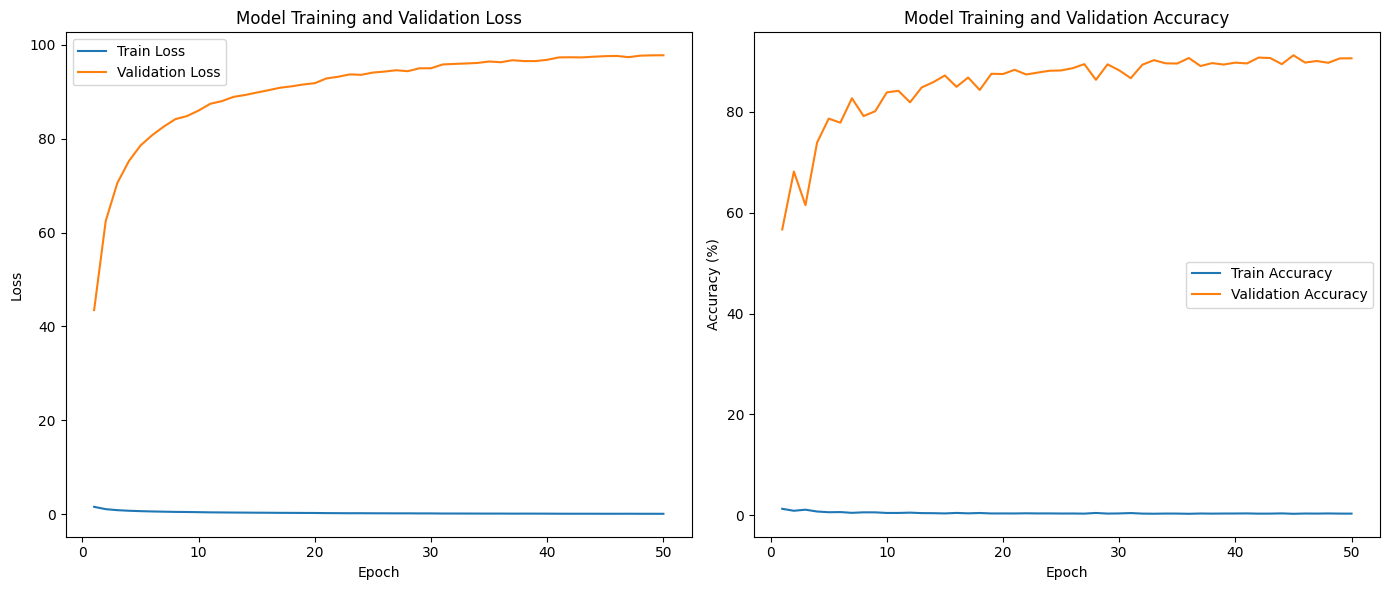

In [21]:
# Best parameters for ResNet-18
best_params_resnet = {
    "learning_rate": 0.0005,
    "batch_size": 128,
    "optimizer": "Adam",
    "weight_decay": 0.0001,
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.9}

# Initialize DataLoader with the best batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params_resnet['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params_resnet['batch_size'], shuffle=False)

# Initialize model with 10 classes (for CIFAR-10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = ResNet_18(num_classes=10).to(device)
summary(resnet_model, (3, 32, 32))
criterion = nn.CrossEntropyLoss()

# Set up the optimizer and scheduler using best parameters
if best_params_resnet['optimizer'] == "Adam":
    optimizer = Adam(resnet_model.parameters(), lr=best_params_resnet['learning_rate'], weight_decay=best_params_resnet['weight_decay'])
else:
    optimizer = SGD(resnet_model.parameters(), lr=best_params_resnet['learning_rate'], momentum=0.9, weight_decay=best_params_resnet['weight_decay'])

scheduler = StepLR(optimizer, step_size=best_params_resnet['scheduler_step_size'], gamma=best_params_resnet['scheduler_gamma'])

# Lists to store metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training for 50 epochs
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(resnet_model, val_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training and validation curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)


### **ResNet18 Training and Validation Accuracy & Loss Curves**

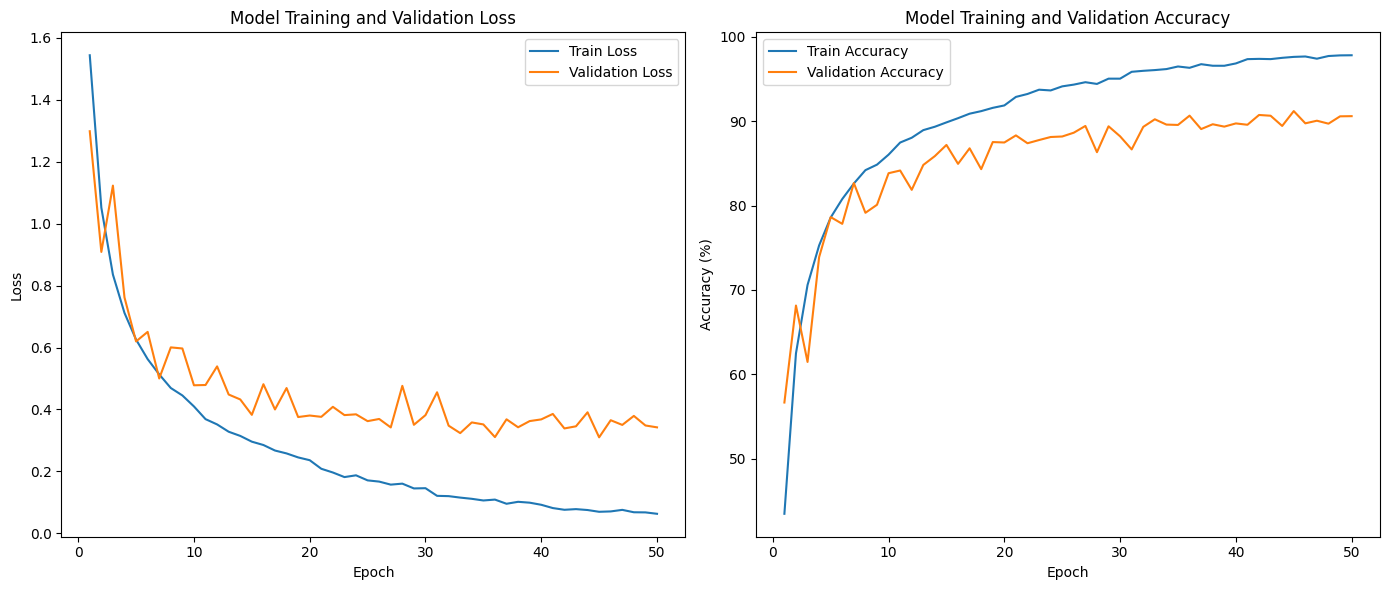

In [24]:
# ResNet-18 Acc&Loss Curve Plots
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

## **Finalized Alexnet**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             880
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
             ReLU-14            [-1, 12

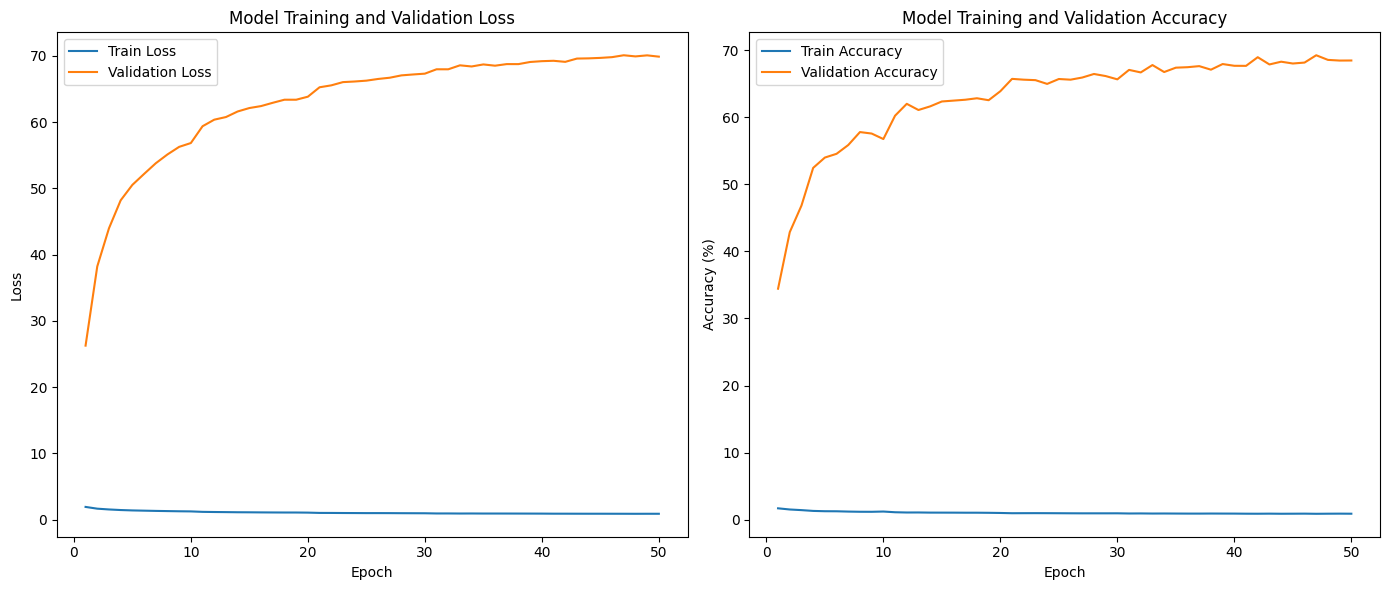

In [22]:
# Best parameters for AlexNet
best_params_alexnet = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "optimizer": "Adam",
    "weight_decay": 0.0001,
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5}

# Initialize DataLoader with the best batch size
train_loader_alexnet = torch.utils.data.DataLoader(train_dataset, batch_size=best_params_alexnet['batch_size'], shuffle=True)
val_loader_alexnet = torch.utils.data.DataLoader(val_dataset, batch_size=best_params_alexnet['batch_size'], shuffle=False)

# Initialize AlexNet model
alexnet_model = AlexNet(num_classes=10).to(device)
summary(alexnet_model, (3, 32, 32))
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = Adam(alexnet_model.parameters(), lr=best_params_alexnet['learning_rate'], weight_decay=best_params_alexnet['weight_decay'])
scheduler_alexnet = StepLR(optimizer_alexnet, step_size=best_params_alexnet['scheduler_step_size'], gamma=best_params_alexnet['scheduler_gamma'])

# Lists to store metrics
train_losses_alexnet, train_accuracies_alexnet = [], []
val_losses_alexnet, val_accuracies_alexnet = [], []

# Training for 50 epochs
num_epochs = 50
for epoch in range(num_epochs):

    train_loss, train_acc = train_one_epoch(alexnet_model, train_loader_alexnet, criterion, optimizer_alexnet, device)
    val_loss, val_acc = evaluate(alexnet_model, val_loader_alexnet, criterion, device)
    scheduler_alexnet.step()


    train_losses_alexnet.append(train_loss)
    train_accuracies_alexnet.append(train_acc)
    val_losses_alexnet.append(val_loss)
    val_accuracies_alexnet.append(val_acc)

    # Print epoch progress
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training and validation curves for AlexNet
plot_training_curves(train_losses_alexnet, train_accuracies_alexnet, val_losses_alexnet, val_accuracies_alexnet)


### **AlexNet Training and Validation Accruacy & Loss Curves**

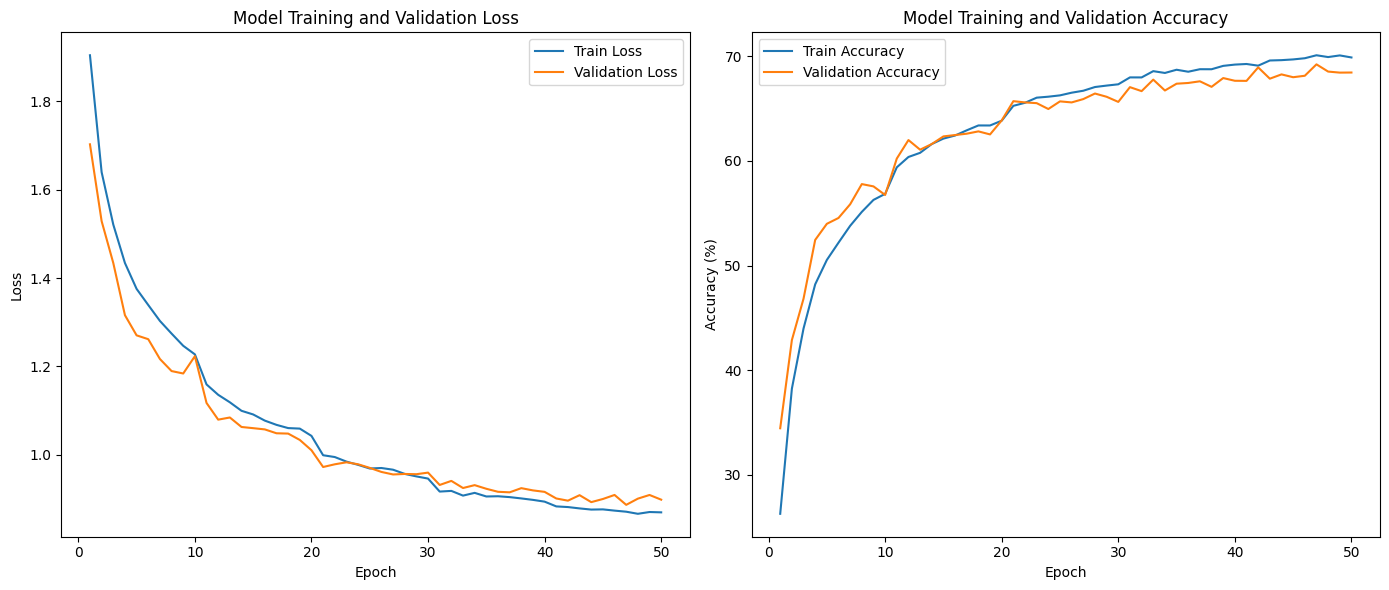

In [23]:
# AlexNet Acc&Loss Curve Plots
plot_training_curves(train_losses_alexnet, val_losses_alexnet, train_accuracies_alexnet, val_accuracies_alexnet)


## **Finalized MobileNetV2**

### **MobileNetV2 Training and Validation Accuracy & Loss Curve**

Epoch 1/50 - Train Loss: 1.6663, Train Acc: 37.72% - Val Loss: 1.4442, Val Acc: 46.94%
Epoch 2/50 - Train Loss: 1.2835, Train Acc: 53.61% - Val Loss: 1.2468, Val Acc: 54.11%
Epoch 3/50 - Train Loss: 1.0875, Train Acc: 60.99% - Val Loss: 1.0715, Val Acc: 61.44%
Epoch 4/50 - Train Loss: 0.9462, Train Acc: 66.50% - Val Loss: 0.9094, Val Acc: 68.20%
Epoch 5/50 - Train Loss: 0.8314, Train Acc: 71.02% - Val Loss: 0.9191, Val Acc: 67.58%
Epoch 6/50 - Train Loss: 0.7516, Train Acc: 74.02% - Val Loss: 0.7784, Val Acc: 72.74%
Epoch 7/50 - Train Loss: 0.6944, Train Acc: 76.17% - Val Loss: 0.7044, Val Acc: 74.92%
Epoch 8/50 - Train Loss: 0.6357, Train Acc: 78.30% - Val Loss: 0.6653, Val Acc: 76.50%
Epoch 9/50 - Train Loss: 0.6072, Train Acc: 79.59% - Val Loss: 0.6843, Val Acc: 76.89%
Epoch 10/50 - Train Loss: 0.5796, Train Acc: 80.17% - Val Loss: 0.5902, Val Acc: 79.51%
Epoch 11/50 - Train Loss: 0.4667, Train Acc: 84.07% - Val Loss: 0.5047, Val Acc: 82.66%
Epoch 12/50 - Train Loss: 0.4348, Train A

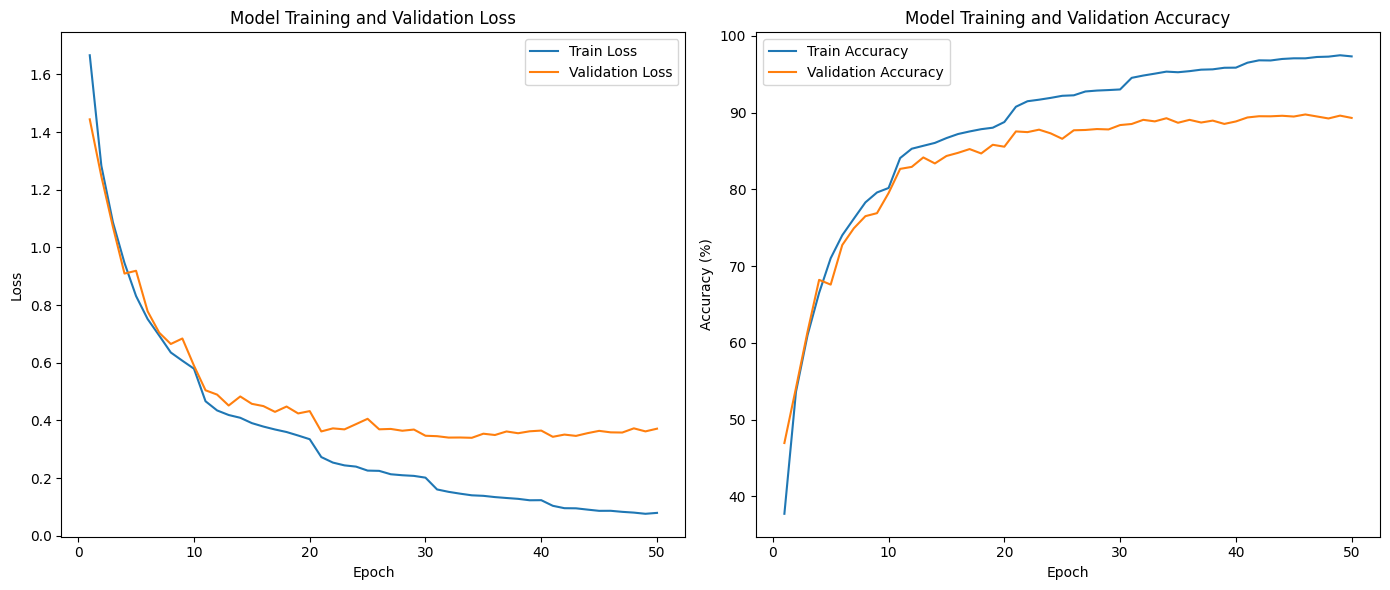

In [26]:
# Best parameters for MobileNetV2
best_params_mobilenet = {
    "learning_rate": 0.001,
    "batch_size": 128,
    "optimizer": "Adam",
    "weight_decay": 0.0005,
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5}

# Initialize DataLoader with the best batch size
train_loader_mobilenet = torch.utils.data.DataLoader(train_dataset, batch_size=best_params_mobilenet['batch_size'], shuffle=True)
val_loader_mobilenet = torch.utils.data.DataLoader(val_dataset, batch_size=best_params_mobilenet['batch_size'], shuffle=False)

# Initialize MobileNetV2 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model = MobileNetV2(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_mobilenet = Adam(mobilenet_model.parameters(), lr=best_params_mobilenet['learning_rate'], weight_decay=best_params_mobilenet['weight_decay'])
scheduler_mobilenet = StepLR(optimizer_mobilenet, step_size=best_params_mobilenet['scheduler_step_size'], gamma=best_params_mobilenet['scheduler_gamma'])

train_losses_mobilenet, train_accuracies_mobilenet = [], []
val_losses_mobilenet, val_accuracies_mobilenet = [], []

# Training for 50 epochs
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(mobilenet_model, train_loader_mobilenet, criterion, optimizer_mobilenet, device)
    val_loss, val_acc = evaluate(mobilenet_model, val_loader_mobilenet, criterion, device)
    scheduler_mobilenet.step()

    train_losses_mobilenet.append(train_loss)
    train_accuracies_mobilenet.append(train_acc)
    val_losses_mobilenet.append(val_loss)
    val_accuracies_mobilenet.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

plot_training_curves(train_losses_mobilenet, val_losses_mobilenet, train_accuracies_mobilenet, val_accuracies_mobilenet)


## **Evaluation on Testing Set**


--- Test Set Performance for ResNet-18 ---
Test Loss: 0.3787, Test Accuracy: 89.59%

--- Class-wise Performance Metrics ---
              precision    recall  f1-score   support

       plane       0.94      0.88      0.91      1000
         car       0.96      0.95      0.96      1000
        bird       0.87      0.88      0.87      1000
         cat       0.87      0.67      0.76      1000
        deer       0.86      0.91      0.88      1000
         dog       0.80      0.89      0.84      1000
        frog       0.93      0.93      0.93      1000
       horse       0.89      0.95      0.92      1000
        ship       0.92      0.96      0.94      1000
       truck       0.92      0.95      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



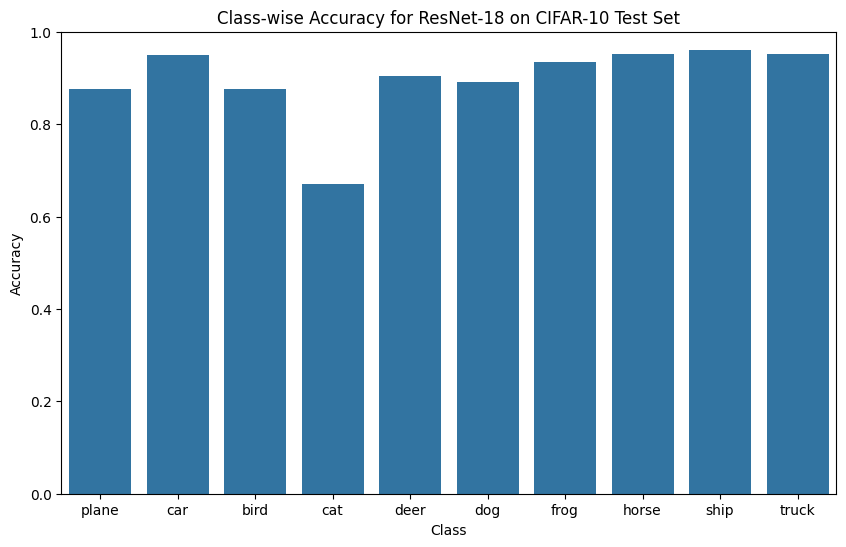

In [35]:
# Calculate test set metrics
test_loss, test_accuracy, test_labels, test_preds = evaluate(resnet_model, test_loader, criterion, device)

# Print test set metrics
print(f"\n--- Test Set Performance for ResNet-18 ---")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Evaluate class-wise performance
plot_confusion_matrix(resnet_model, test_loader, classes)

### **Testing Set Confusion Matrix & Visualization**

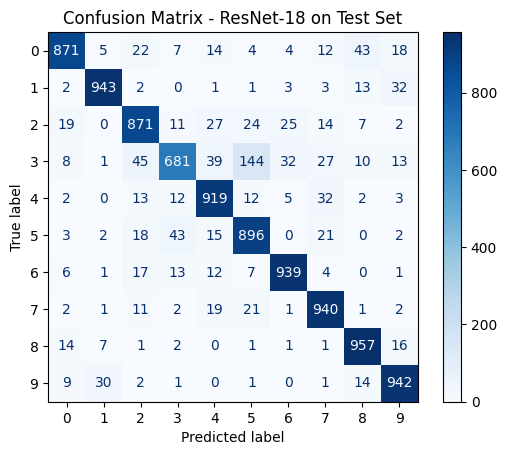

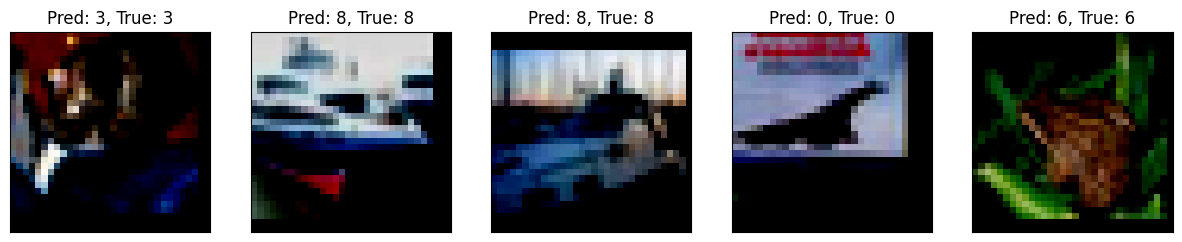

In [43]:
#  Generate and display a confusion matrix to visualize misclassification patterns
conf_matrix = confusion_matrix(test_labels, test_preds)
# Generate a detailed classification report for class-wise metrics (precision, recall, F1-score)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ResNet-18 on Test Set")
plt.show()
visualize_test_results(test_loader, resnet_model, device)